# A simple example of structure from motion.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmosZhu/Dizhong_PythonUtils/blob/main/Notebooks/MultipleView_Geometry/Structure_f_motion.ipynb)

This notebook includes following keypoints:
- Estimate fundamental from pair of images.
- Estimate essential matrix from fundamental matrix.
- Estimate rotation and translation from essential matrix.
- Estimate projection matrix from 3D and 2D corresponding points.
- Trianguate 3D point cloud from set of image features.
- Bundle adjustment.

**You need to install plotly to see the interactive 3D scene.**

### 0. Import path and load packages

In [19]:
import sys

sys.path.insert(0, '../../')
# %matplotlib

########################################################################################################################
#   If you are in colab, then you can uncomment following command to install some packages for you, but I found out
#   a lot of compatible issue such as import plotly and load images.
#   So I suggest you download them an run locally.
#
#
# !git clone https://github.com/AmosZhu/Dizhong_PythonUtils.git
# sys.path.insert(0, 'Dizhong_PythonUtils')
# !pip install "git+https://github.com/facebookresearch/pytorch3d.git@stable"
# !pip install open3d
#
########################################################################################################################

In [20]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from GeoUtils.Geo3D import (
    Epipolar,
    PnP,
)
from GeoUtils.Geo3D import reconstruction
from GeoUtils.Cameras.cameras import backProjection
from GeoUtils_pytorch.Cameras.PerspectiveCamera import (
    PerspectiveCamera
)
from GeoUtils_pytorch.Geo3D import bundlAdjustment as BA
import open3d as o3d
from utils.plots import (
    plot_landmarks,
    plot_imageset,
    plot_realsize
)
from utils.plotly_helper import (
    plotly_pointcloud_and_camera
)

device = 'cpu'

### 1. Load images and compute fundamental matrix between first pair
Load **Temple Ring** image sets and display.

There are 5 images in total


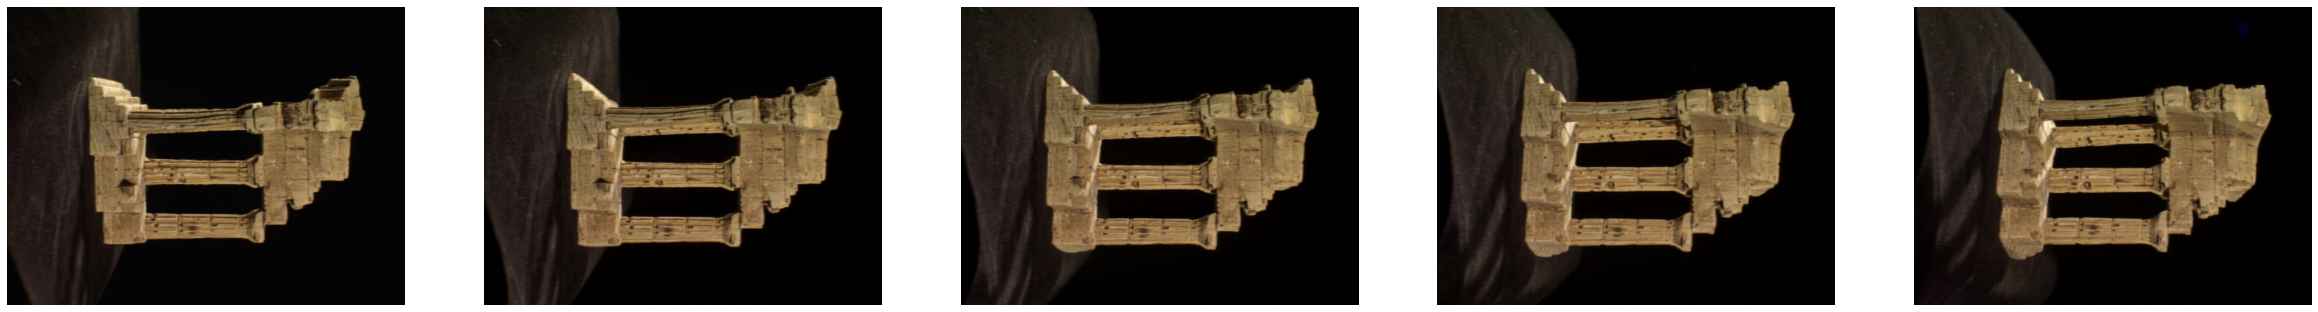

In [21]:
from test_datas.templeRing import datahelper

noofImages = 5
images, (Ks, Rs, ts) = datahelper.load_data(noofImages)

noofImages = images.shape[0]
h, w = images.shape[1], images.shape[2]
_ = plot_imageset(images, nrow=1)

#### Detect features for images

In [22]:
# We loop through all images and detect the SIFT features and saved
SIFT = cv2.SIFT_create()
keypoints = []
descriptors = []
feature_list = []
for i in range(noofImages):
    kp, des = SIFT.detectAndCompute(images[i], None)
    feature_list.append({'kp': kp,
                         'des': des,
                         'px': np.array([p.pt for p in kp], dtype=np.float32),
                         'row': -np.ones(len(kp), dtype=np.int32)})

#### Compute fundamental matrix from first pair
To compute the fundamental matrix, we need pairs of features that match in both images. For all corresponding features $x_1 \leftrightarrow x_2 $, it must satisfy that
\begin{equation}
    x_1 F x_2 =0
\end{equation}
We can formulate above equation in $Ax=0$, then solve using SVD. While $F$ has 8 parameters, we need at least four corresponding features. Where each correspondence provide two equations.

Let's first find the corresponding features in a pair of image.

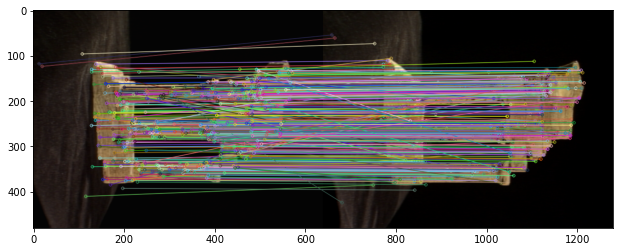

In [23]:
# build a brute force matcher
bf = cv2.BFMatcher(crossCheck=True)

# get an initial match points
img1 = images[0]
des1 = feature_list[0]['des']
kp1 = feature_list[0]['kp']
img2 = images[1]
des2 = feature_list[1]['des']
kp2 = feature_list[1]['kp']

# Match the descriptor between images
matches = bf.match(des1, des2)
matchPoints_1 = []
matchPoints_2 = []
# get the match points
for k, m in enumerate(matches):
    matchPoints_1.append(kp1[m.queryIdx].pt)
    matchPoints_2.append(kp2[m.trainIdx].pt)

matchPoints_1 = np.array(matchPoints_1)
matchPoints_2 = np.array(matchPoints_2)

img_match = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plot_realsize(img_match)
plt.imshow(img_match)
plt.show()

We can see there some mismatch between the corresponding features, because it not satisfies the epipolar geometry constraint. To get rid of the outliers, we use RANSAC technic when computing fundamental matrix to force the inliers to meet epipolar constraint.

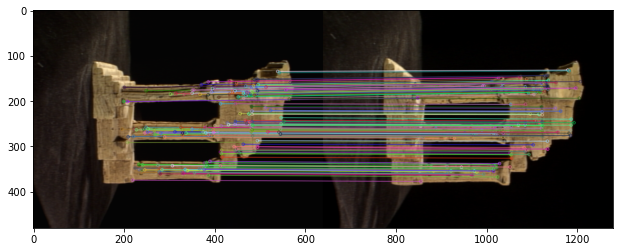

In [24]:
# as we use RANSAC to compute fundamental matrix, it might be a good idea to iteratively compute F until number of correspondences stay stable.
def compute_F_to_converge(px1, px2):
    bConverge = False
    F, mask = cv2.findFundamentalMat(px1, px2, cv2.FM_LMEDS)
    epipolar_matches = [match for i, match in enumerate(matches) if mask[i] == 1]
    nInliers = len(epipolar_matches)
    while not bConverge:
        mask = mask.squeeze() == 1
        px1 = px1[mask]
        px2 = px2[mask]
        F, mask = cv2.findFundamentalMat(px1, px2, cv2.FM_LMEDS)
        epipolar_matches = [match for i, match in enumerate(epipolar_matches) if mask[i] == 1]
        if len(epipolar_matches) == nInliers:
            bConverge = True
        nInliers = len(epipolar_matches)

    return F, epipolar_matches, (px1, px2)


# Let's compute fundamental matrix to force epipolar constraint
F, epipolar_matches, (matchPoints_1, matchPoints_2) = compute_F_to_converge(matchPoints_1, matchPoints_2)

img_match = cv2.drawMatches(img1, kp1, img2, kp2, epipolar_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plot_realsize(img_match)
plt.imshow(img_match)
plt.show()

### 2. Compute the essential matrix from the fundamental matrix
Essential matrix is defined as
\begin{equation}
    E=K_2^T F K_1
\end{equation}
While the $K_2$ is the intrinsic camera matrix for second view, and $K_1$ is the intrinsic camera matrix for first view.
**So it means we have to calibrate the camera in advance to get $K$**

In [25]:
K = Ks[0]
E = Epipolar.E_f_F(F, K)

After get essential matrix then we are able to retrieve the rotation and translation from the essential matrix, because of:
\begin{equation}
    E=t_\times \times R
\end{equation}
where $t_\times$ is skew matrix of $t$.

#### Compute rotation and translations
1. We apply SVD on essential matrix that $U,D,V^H=\text{SVD}(E)$.
2. The rotation matrix is $R_1=UWV^H$ or $R_2=UW^TV^H$.
3. Check the determinant of $R_1$ and $R_2$, set $R_1=-R_1$ if $det(R_1)<0$. Same for $R_2$.
4. The translation is $t_1=UZU^T$ or $t_2=UZ^TU^T$. Also you can see that $t_1=-t_2$.

Where
\begin{equation}
    W=
    \begin{bmatrix}
        0 &-1 &0 \\
        1 &0 &0 \\
        0 &0 &1
    \end{bmatrix} \ \ \  \text{and} \ \ \
    Z=
    \begin{bmatrix}
        0 &1 &0 \\
        -1 &0 &0 \\
        0 &0 &0
    \end{bmatrix}
\end{equation}

So there are 4 possible combination of rotation and translation from essential matrix where are:
$(R_1,t_1), (R_1,t_2), (R_2,t_1), (R_2,t_2)$.

In [26]:
Rs, ts = Epipolar.Rt_f_E(E)
print(f'rotation shape {Rs.shape}, translation shape {ts.shape}')

rotation shape (4, 3, 3), translation shape (4, 3)


#### Get correct rotation and translation
There is only one pair of rotation and translation is correct. Which satisfy: under this pair of matrix, the reconstructed 3D point are all set in front of both cameras.
So we need firstly reconstruct the 3D points using triangulation. Let defined $x$ as pixel coordinate, $P$ as camera projection matrix, $X$ as corresponding 3D position of $x$. So we have
\begin{equation}
    x=PX \ \ \ => \ \ x_\times PX=0
\end{equation}
While $X$ has 3 unknowns, we need at least two views to solve it. You can see above function is able to refactor in form $Ax=0$ then solve by SVD.

After getting 3D points, we can transform them to each camera coordinate and test the z coordinate whether they are in front of the cameras. We keep track all results and return the one has the least negative depth.

In [27]:
# All the steps has been implemented inside here.
R_est, t_est, pt3D = reconstruction.PoseEstimation_f_F_K(F, matchPoints_1, matchPoints_2, K)

# we use open3D to get rid of some outliers
scene_points = pt3D  # initial scene points
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(scene_points)
cl, ind = pcd.remove_statistical_outlier(nb_neighbors=30, std_ratio=1)
scene_points_inlier = np.zeros(pt3D.shape[0], dtype=bool)
scene_points_inlier[ind] = True

# we display the reconstructed 3D points and corresponding cameras
M = np.zeros(shape=(2, 4, 4), dtype=np.float32)
M[..., 3, 3] = 1.0
M[0, :3, :3] = np.eye(3)
M[1, :3, :3] = R_est.T
M[1, :3, 3] = -R_est.T @ t_est

fig = plotly_pointcloud_and_camera(pt3D=scene_points[scene_points_inlier], cam_matrices=M)
fig.show()

### 3. Add new view using PnP and bundle adjustment
As we have an initial pair with estimated 3D point cloud and camera, we can use PnP to add new view instead of estimate fundamental matrix pair sequentially. Because it doesn't guarantee the new 3D points are in the same scale.

We setup a feature list table to track the corresponding features on set of views, and we will do a bundle adjustment using all view information.
Let's firstly add some helping functions for this.

In [28]:
# This function helps to track feature positions in all views
def update_feature_list(feature_list, epipolar_matches, indices_pair, feature_count=0):
    i, j = indices_pair[0], indices_pair[1]
    for m in epipolar_matches:
        idx_i = m.queryIdx
        idx_j = m.trainIdx
        if feature_list[i]['row'][idx_i] == -1 and feature_list[j]['row'][idx_j] == -1:
            feature_list[i]['row'][idx_i] = feature_count
            feature_list[j]['row'][idx_j] = feature_count
            feature_count += 1
        elif feature_list[i]['row'][idx_i] == -1 and feature_list[j]['row'][idx_j] != -1:
            feature_list[i]['row'][idx_i] = feature_list[j]['row'][idx_j]
        elif feature_list[j]['row'][idx_j] == -1 and feature_list[i]['row'][idx_i] != -1:
            feature_list[j]['row'][idx_j] = feature_list[i]['row'][idx_i]
        else:
            continue

    return feature_list, feature_count


# This function will return a visible mask, and indices to refer the feature positions.
def construct_matching_table(feature_list):
    nView = len(feature_list)

    nMaxFeat = 0
    for i in range(nView):
        nMaxFeat += len(feature_list[i]['row'])

    vis_table = np.zeros(shape=(nView, nMaxFeat), dtype=bool)
    idx_table = np.zeros(shape=(nView, nMaxFeat), dtype=int)

    for i in range(nView):
        js = np.where(feature_list[i]['row'] != -1)[0]
        idx = feature_list[i]['row'][js]
        vis_table[i, idx] = True
        idx_table[i, idx] = js

    trunk_idx = np.where(np.all(vis_table == False, axis=0))[0][0]
    return vis_table[..., :trunk_idx], idx_table[..., :trunk_idx]

As we compute the first pair of images already, we save the corresponding features in the feature list.
In the mean while, we save the computed camera information as well.

In [29]:
feature_count = 0
feature_list, feature_count = update_feature_list(feature_list, epipolar_matches, (0, 1), feature_count=feature_count)

#### Let's add the third view.
We firstly need to figure out the corresponding features between (1st, 3rd) view and (2nd, 3rd) views.

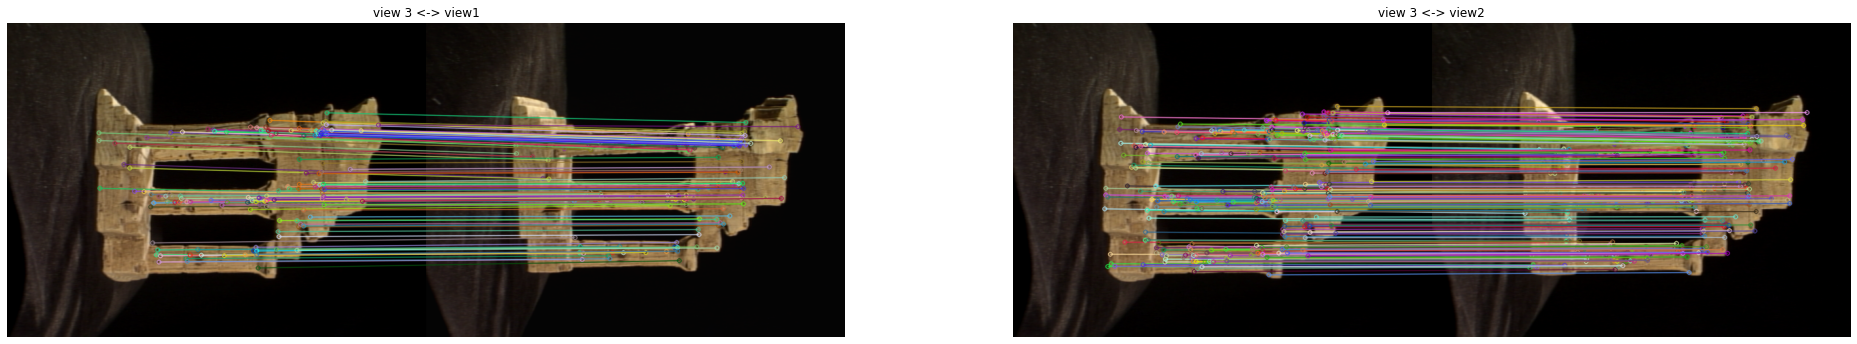

In [30]:
i = 2  # we are in view 3
desi = feature_list[i]['des']
kpi = feature_list[i]['kp']
imgi = images[i]

disp_images = []  # store the corresponding images here.
disp_titles = []
for j in range(i):
    desj = feature_list[j]['des']
    kpj = feature_list[j]['kp']
    imgj = images[j]

    # get an initial match points
    matches = bf.match(desi, desj)
    matchPoints_i = []
    matchPoints_j = []
    # get the match points
    for k, m in enumerate(matches):
        matchPoints_i.append(kpi[m.queryIdx].pt)
        matchPoints_j.append(kpj[m.trainIdx].pt)

    matchPoints_i = np.array(matchPoints_i)
    matchPoints_j = np.array(matchPoints_j)

    F, epipolar_matches, (matchPoints_i, matchPoints_j) = compute_F_to_converge(matchPoints_i, matchPoints_j)

    match_img = cv2.drawMatches(imgi, kpi, imgj, kpj, epipolar_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    disp_images.append(match_img)
    disp_titles.append(f'view {i + 1} <-> view{j + 1}')

    if matchPoints_i.shape[0] < 100:
        continue  # if there are few corresponding features, ignore this pair

    feature_list, feature_count = update_feature_list(feature_list, epipolar_matches, indices_pair=(i, j), feature_count=feature_count)

_ = plot_imageset(np.stack(disp_images), nrow=1, titles=disp_titles)

Now we've setup the corresponding feature for 3rd views. Because we've reconstructed some 3D point from (1st,2nd) view pair, we can use them to build 3D<->2D correspondences in 3rd view

In [31]:
vis_table, idx_table = construct_matching_table(feature_list[:i + 1])
# Now we start to use PnP, don't use pairwise estimation, because the projection matrix from fundamental is not unique. The reconstruction point might be in different scale
# looking for 3D and 2D correspondence for PnP
n3Dpoints = len(scene_points)
visible_3D_mask = vis_table[i, :n3Dpoints]  # we are now in ith view, we only take the 3D points visible by this view
if scene_points_inlier is not None:
    visible_3D_mask = visible_3D_mask & scene_points_inlier
visible_3D_pt = scene_points[visible_3D_mask]

# now take the feature only with visible 3D points
trunk_idx = idx_table[i, :n3Dpoints][visible_3D_mask]  # because the len(feature_table)>=len(scene_points)
indices_i = trunk_idx[trunk_idx != -1]
visible_px = feature_list[i]['px'][indices_i]

As we've seen in triangulation section that $x_\times PX=0$, but now this time we have known $(x, X)$. We can have following equation
\begin{equation}
    \begin{bmatrix}
        0_{1\times4} &-X^T &vX^T\\
        x^T &0_{1\times4} &-uX^T\\
        -vX^T &uX^T &0_{1\times4}
    \end{bmatrix}\cdot
    \begin{bmatrix}
        P_1^T \\ P_2^T \\P_3^T
    \end{bmatrix} = \mathbf{0}
\end{equation}
where $x=[u, v, 1]$, $P_i$ is the $i^{th}$ row of the $P$. $X$ is in homogenous coordinate.
The above equation can be solve by SVD, and $P$ has 12 unknowns at least we need 6 correspondences.

In [32]:
P = PnP.P_f_PnP(visible_px, visible_3D_pt)

#### Get rotation, translation and scale from projection matrix with given intrinsic matrix.
As $P=\lambda K[R |t]$, we can set $R=K^{-1}P_{1:3}$.
**The rotation need to satisfy the constraint that $RR^T=I$**. We enforce this constraint by $U,D,V^H=\text{SVD}(R)$.
- The new rotation then will be
\begin{equation}
    $R^\prime=UV^H$
\end{equation}
- The scale can be set to $\lambda=(\prod_{i=1}^3{D_i})^{1/3}$.
- The translation can be set to $t=K^{-1}P_{4}$.

We do a non-linear optimisation to get a better camera estimation by minimising the cost function that: $\min_{s,R,t} \sum_{i=0}^N||x_i-P(s,R,t)X_i||$.

[Camera Bundle Adjustment 9999/10000] loss: 14.643203: 100%|██████████| 10000/10000 [00:29<00:00, 336.43it/s]


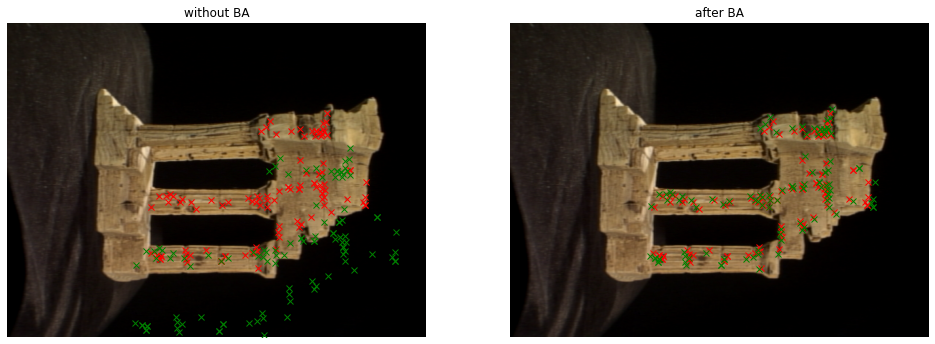

In [33]:
R_est, t_est, s_est = PnP.Rts_f_P_K(P, K)
# R_est, t_est, s_est = PnP.Rts_f_PnP_K(visible_px, visible_3D_pt, K)

P_rect = s_est * K @ np.concatenate([R_est, t_est[..., None]], axis=-1)
# back project 3D points to image
img_pt1 = backProjection(P_rect, visible_3D_pt)

# let's do bundle adjustment
cameras = PerspectiveCamera(
    intrinsic=torch.from_numpy(K[None]).float(),
    rotation=torch.from_numpy(R_est[None]).float(),
    translation=torch.from_numpy(t_est[None]).float(),
    scale=torch.from_numpy(s_est[None]).float(),
).to(device)
cameras_new = BA.Rts_f_BA_K(cameras=cameras,
                            px=torch.from_numpy(visible_px[None]).float().to(device),
                            pc_init=torch.from_numpy(visible_3D_pt).float().to(device),
                            )
R_new = cameras_new.R.detach().cpu().numpy()[0]
t_new = cameras_new.t.detach().cpu().numpy()[0]
s_new = cameras_new.s.detach().cpu().numpy()[0]
P_new = cameras_new.P.detach().cpu().numpy()[0]

img_pt2 = backProjection(P_new, visible_3D_pt)
_ = plot_landmarks(np.stack([images[i]] * 2), ld1=np.stack([visible_px] * 2), ld2=np.stack([img_pt1, img_pt2]), titles=['without BA', 'after BA'])

Let's plot these 3 views

In [34]:
M_new = np.zeros(shape=(3, 4, 4), dtype=np.float32)
M_new[:2, ...] = M
M_new[2, :3, :3] = R_new.T
M_new[2, :3, 3] = -R_new.T @ t_new
M_new[..., 3, 3] = 1.0

fig = plotly_pointcloud_and_camera(pt3D=[scene_points[scene_points_inlier]], cam_matrices=M_new)
fig.show()

#### 4. Put everything together
Let's now put everything together to reconstruct the scene and estimate pose

In [35]:
def image_outliers(imgpt, h, w):
    outlier_x = (imgpt[..., 0] < 0) | (imgpt[..., 0] >= w)
    outlier_y = (imgpt[..., 1] < 0) | (imgpt[..., 1] >= h)
    outliers = outlier_x | outlier_y

    return np.any(outliers, 0)


feature_list = []
for i in range(noofImages):
    kp, des = SIFT.detectAndCompute(images[i], None)
    feature_list.append({'kp': kp,
                         'des': des,
                         'px': np.array([p.pt for p in kp], dtype=np.float32),
                         'row': -np.ones(len(kp), dtype=np.int32)})

scene_points = None
scene_points_inlier = None  # if some scenepoint back project out of the image, then we consider as an outlier
feature_count = 0

K = Ks[0]
K_tensor = torch.from_numpy(K[None]).to(device).float()
# cams = {'K': None, 'R': None, 't': None, 'P': None}
cams = PerspectiveCamera().to(device)

for i in range(1, noofImages):
    desi = feature_list[i]['des']
    kpi = feature_list[i]['kp']
    imgi = images[i]

    for j in range(i):
        desj = feature_list[j]['des']
        kpj = feature_list[j]['kp']
        imgj = images[j]

        # get an initial match points
        matches = bf.match(desi, desj)
        matchPoints_i = []
        matchPoints_j = []
        # get the match points
        for k, m in enumerate(matches):
            matchPoints_i.append(kpi[m.queryIdx].pt)
            matchPoints_j.append(kpj[m.trainIdx].pt)

        matchPoints_i = np.array(matchPoints_i)
        matchPoints_j = np.array(matchPoints_j)

        # Let's compute fundamental matrix to force epipolar constraint
        F, epipolar_matches, (matchPoints_i, matchPoints_j) = compute_F_to_converge(matchPoints_i, matchPoints_j)

        if matchPoints_i.shape[0] < 100:
            continue  # if there are few inliers, ignore this pair

        # epipolar_matches = [match for i, match in enumerate(matches) if mask[i] == 1]

        feature_list, feature_count = update_feature_list(feature_list, epipolar_matches, (i, j), feature_count=feature_count)

    ## once we've done pairwise point matching, we can do incremental reconstruction now
    vis_table, idx_table = construct_matching_table(feature_list[:i + 1])
    if i == 1:  # we compute only by fundamental matrix to build a start point, a more proper way is to choose the one has large baseline and most features between pairs.
        px1 = feature_list[0]['px'][idx_table[0]]
        px2 = feature_list[1]['px'][idx_table[1]]
        F, mask = cv2.findFundamentalMat(px1, px2, cv2.FM_8POINT)  # these points are all inliers

        E = Epipolar.E_f_F(F, K)
        R_est, t_est, pt3D = reconstruction.PoseEstimation_f_F_K(F, px1, px2, K)

        cams.add_f_numpy(intrinsic=K[None],
                         rotation=np.eye(3)[None],
                         translation=np.zeros(3)[None])

        cams.add_f_numpy(rotation=R_est[None],
                         translation=t_est[None])

        scene_points = pt3D  # initial scene points
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(scene_points)
        cl, ind = pcd.remove_statistical_outlier(nb_neighbors=30, std_ratio=1)
        scene_points_inlier = np.zeros(pt3D.shape[0], dtype=bool)
        scene_points_inlier[ind] = True
        # o3d.visualization.draw_geometries([cl])
    else:
        # Now we start to use PnP, don't use pairwise estimation, because the projection matrix from fundamental is not unique. The reconstruction point might be in different scale
        # looking for 3D and 2D correspondence for PnP
        n3Dpoints = len(scene_points)
        visible_3D_mask = vis_table[i, :n3Dpoints]  # we are now in ith view, we only take the 3D points visible by this view
        if scene_points_inlier is not None:
            visible_3D_mask = visible_3D_mask & scene_points_inlier
        visible_3D_pt = scene_points[visible_3D_mask]

        # now take the feature only with visible 3D points
        trunk_idx = idx_table[i, :n3Dpoints][visible_3D_mask]  # because the len(feature_table)>=len(scene_points)
        indices_i = trunk_idx[trunk_idx != -1]
        visible_px = feature_list[i]['px'][indices_i]

        R_est, t_est, s_est = PnP.Rts_f_PnP_K(visible_px, visible_3D_pt, K)

        # let's do bundle adjustment
        cameras = PerspectiveCamera(
            intrinsic=torch.from_numpy(K[None]).float(),
            rotation=torch.from_numpy(R_est[None]).float(),
            translation=torch.from_numpy(t_est[None]).float(),
            scale=torch.from_numpy(s_est[None]).float(),
        ).to(device)
        cameras_new = BA.Rts_f_BA_K(cameras=cameras,
                                    px=torch.from_numpy(visible_px[None]).float().to(device),
                                    pc_init=torch.from_numpy(visible_3D_pt).float().to(device),
                                    message=f'view {i + 1}:'
                                    )
        cams.add(rotation=cameras_new.R,
                 translation=cameras_new.t,
                 scale=cameras_new.s)

        pxs = np.stack([feature_list[k]['px'][idx_table[k]] for k in range(i + 1)])
        vis_mask = vis_table[:i + 1]

        pt3D = reconstruction.triangulateReconstruction(pxs=pxs, cams=cams.P.detach().cpu().numpy(), mask=vis_mask)

        # let's do bundle adjustment
        scene_points_inlier_BA = np.zeros(pt3D.shape[0], dtype=bool)
        scene_points_inlier_BA[:n3Dpoints] = scene_points_inlier
        cams, pt3D = BA.RtsPC_f_BA_K(cams,
                                     px=torch.from_numpy(pxs).float().to(device),
                                     pc_init=torch.from_numpy(pt3D).float().to(device),
                                     px_mask=torch.from_numpy(vis_mask).to(device),
                                     pc_mask=torch.from_numpy(scene_points_inlier_BA).to(device),
                                     message=f'view {i + 1}:'
                                     )
        img_pt = cams.point_to_image(pt3D).detach().cpu().numpy()
        img_inliers = ~image_outliers(img_pt, h, w)
        # _ = plot_landmarks(images[:i + 1], pxs[:, img_inliers], img_pt[:, img_inliers])

        pt3D = pt3D.detach().cpu().numpy()
        # remove outliers
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(pt3D)
        cl, ind = pcd.remove_statistical_outlier(nb_neighbors=30, std_ratio=1)
        scene_points_inlier = np.zeros(pt3D.shape[0], dtype=bool)
        scene_points_inlier[ind] = True
        scene_points = pt3D
    pass

view 3:[Camera Bundle Adjustment 6469/10000] loss: 0.382524:  65%|██████▍   | 6470/10000 [00:18<00:10, 348.75it/s]
view 3:[Camera & PointCloud Bundle Adjustment 9999/10000] loss: 0.007466: 100%|██████████| 10000/10000 [00:39<00:00, 253.91it/s]
view 4:[Camera Bundle Adjustment 2408/10000] loss: 3.537417:  24%|██▍       | 2409/10000 [00:06<00:21, 350.41it/s]
view 4:[Camera & PointCloud Bundle Adjustment 9999/10000] loss: 0.017142: 100%|██████████| 10000/10000 [00:39<00:00, 252.43it/s]
view 5:[Camera Bundle Adjustment 6124/10000] loss: 14.387872:  61%|██████▏   | 6125/10000 [00:17<00:10, 352.77it/s]
view 5:[Camera & PointCloud Bundle Adjustment 9999/10000] loss: 2.984748: 100%|██████████| 10000/10000 [00:41<00:00, 243.23it/s] 


Display the reconstructed scene and cameras

In [36]:
M = np.zeros(shape=(noofImages, 4, 4), dtype=np.float32)
M[..., 3, 3] = 1.0
M[..., :3, :3] = cams.orientation.detach().cpu().numpy()
M[..., :3, 3] = cams.C.detach().cpu().numpy()

fig = plotly_pointcloud_and_camera(pt3D=[scene_points[scene_points_inlier]], cam_matrices=M)
fig.show()